# STT model training

## Imports + model creation

These cells shows how to create multiple `STT` architectures such as `Jasper`, `DeepSpeech2` or the newly added `ConformerTransducer` architecture. 

In [1]:
import pandas as pd
import tensorflow as tf

from models.stt import DeepSpeech, Jasper, TransformerSTT, ConformerTransducer
from datasets import get_dataset, train_test_split, prepare_dataset, test_dataset_time
from utils import plot_spectrogram, load_json
from utils.text import get_symbols
from utils.audio import display_audio, load_audio, load_mel
from models import get_pretrained, get_model_dir

gpus = tf.config.list_physical_devices('GPU')

model_name = "test_conformer_fr"


print("Tensorflow version : {}".format(tf.__version__))
print("Available GPU's ({}) : {}".format(len(gpus), gpus))

Tensorflow version : 2.6.2
Available GPU's (1) : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
cleaners = ['french_cleaners']

vocab = get_symbols('fr', maj = False, ponctuation = 0)
print(vocab)

['_', '-', ' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'à', 'é', 'è', 'ê', 'î', 'ç', 'ô', 'ù']


In [5]:
model = Jasper.build_pretrained_jasper(
    nom = model_name, lang = 'fr', vocab = vocab, cleaners = cleaners
)
print(model)

Initializing submodel : stt_model !
Submodel stt_model saved in pretrained_models\casper\saving\stt_model.json !
Model casper initialized successfully !
Variables 540 shapes mismatch ((1, 1024, 37) vs (1, 1024, 29)), making partial transfer
Variables 541 shapes mismatch ((37,) vs (29,)), making partial transfer
Weights transfered successfully !
Submodel stt_model saved in pretrained_models\casper\saving\stt_model.json !

========== casper ==========
Sub model stt_model
- Inputs 	: (None, None, 64)
- Outputs 	: (None, None, 37)
- Number of layers 	: 280
- Number of parameters 	: 332.763 Millions
- Model not compiled

Already trained on 0 epochs (0 steps)

Language : fr
Audio rate : 16000
Mel channels : 64
Use CTC decoder : True
Output vocab (size = 37) : ['_', '-', ' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'à', 'é', 'è', 'ê', 'î', 'ç', 'ô', 'ù']



In [ ]:
model = DeepSpeech.build_pretrained_deep_speech(
    nom = model_name, lang = 'fr', vocab = vocab, cleaners = cleaners
)
print(model)

In [2]:
model = ConformerTransducer.clone(
    pretrained = 'stt_fr_conformer_transducer_large', nom = model_name
)
print(model)

When using token / word-level tokenizer, it can be useful to add 'detach_punctuation' in cleaners
Model restoration from pretrained_models\stt_fr_conformer_transducer_large\saving...
Initializing submodel : stt_model !
Successfully restored stt_model from pretrained_models/stt_fr_conformer_transducer_large/saving/stt_model.json !
Loading checkpoint pretrained_models\stt_fr_conformer_transducer_large\saving\ckpt-2
Submodel stt_model saved in pretrained_models\test_conformer_fr\saving\stt_model.json !
Model test_conformer_fr initialized successfully !
Submodel stt_model saved in pretrained_models\test_conformer_fr\saving\stt_model.json !

========== test_conformer_fr ==========
Sub model stt_model
- Inputs 	: unknown
- Outputs 	: unknown
- Number of layers 	: 3
- Number of parameters 	: 119.296 Millions
- Model not compiled

Transfer-learning from : stt_fr_conformer_transducer_large
Already trained on 0 epochs (0 steps)

- Language : en
- Vocabulary (size = 128) : ['<unk>', 'e', 's', 't'

This cell allows to modify the `text_encoder` of a model to another `text_encoder` (in this case, from another model).

In [ ]:
from models.weights_converter import partial_transfer_learning

pretrained_model = 'stt_fr_conformer_transducer_large'
model.set_text_encoder(pretrained_model, lang = 'fr')

partial_transfer_learning(get_pretrained(pretrained_model).stt_model, model.stt_model)
model.save()

print(model)

In [3]:
print(model.text_encoder)

========== Text encoder ==========
Vocab (size = 129) : ['<unk>', 'e', 's', 't', 'i', '▁', 'a', 'o', 'é', 'r', 'u', 'm', 'l', 'c', "'", 'p', '▁de', '▁d', 'on', 'd', '▁s', 'n', 'es', 'v', 'er', '▁c', '▁m', 'g', 'in', '▁l', '▁p', 're', '▁la', '▁a', '▁f', 'b', 'is', 'an', 'it', '▁n', 'en', '▁le', '▁et', '▁t', 'ou', 'f', 'ait', '▁v', 'ent', 'or']
Config : {
  "level": 1,
  "lstrip": false,
  "rstrip": false,
  "cleaners": [
    "french_cleaners"
  ],
  "split_pattern": null,
  "pad_token": "<pad>",
  "sep_token": null,
  "ukn_token": null,
  "sos_token": "[SOS]",
  "eos_token": "[EOS]",
  "mask_token": null,
  "sub_word_prefix": "",
  "use_sos_and_eos": false
}


## Model initialization

In [ ]:
model = get_pretrained(model_name)

lr_config = {
    'name' : 'DivideByStep',
    'maxval' : 1e-3,
    'minval' : 1e-4,
    'factor' : 5
}

model.compile(
    optimizer = 'adam', 
    optimizer_config = {'lr' : lr_config}
)

print(model)

In [ ]:
dataset_name = ['siwis', 'voxforge', 'common_voice']
dataset = get_dataset(
    dataset_name, accent = 'france',
    embedding_dim = model.embedding_dim if hasattr(model, 'embedding_dim') else None,
    embedding_name = 'embeddings_256_mel_lstm'
)

train, valid = None, None

print("Dataset length : {}".format(len(dataset)))

In [3]:
dataset_name = ['siwis']
dataset = get_dataset(
    dataset_name, accent = 'france',
    embedding_dim = model.embedding_dim if hasattr(model, 'embedding_dim') else None,
    embedding_name = 'embeddings_256_mel_lstm'
)

train, valid = None, None

print("Dataset length : {}".format(len(dataset)))

Loading dataset siwis...
Dataset length : 9763


In [ ]:
for _, row in dataset.sample(10, random_state = 0).iterrows():
    enc = model.encode_text(row['text'])
    display_audio(row['filename'])
    plot_spectrogram(model.get_audio(row))
    print('Original : {}\nDecoded  : {}'.format(row['text'], model.decode_text(enc)))

## Training

In [ ]:
model.summary()
model.stt_model.decoder.trainable = False
model.summary()

In [ ]:
""" Classic hyperparameters """
epochs     = 3
batch_size = 8
valid_batch_size = 2 * batch_size
train_prop = 0.9
train_size = min(1024 * 16 * batch_size, int(len(dataset) * train_prop))
valid_size = min(len(dataset) - train_size, 250 * valid_batch_size)

shuffle_size    = batch_size * 16
pred_step       = -10
augment_prct    = 0.25

""" Custom training hparams """
trim_audio      = False
reduce_noise    = False
trim_threshold  = 0.075
max_silence     = 0.25
trim_method     = 'window'
trim_mode       = 'start_end'

trim_mel     = False
trim_factor  = 0.6
trim_mel_method  = 'max_start_end'

max_input_length = 256 * 3

""" Training """

# this is to normalize dataset usage so that you can use a pre-splitted dataset or not
# without changing anything in the training configuration
if train is None or valid is None:
    train, valid = train_test_split(
        dataset, train_size = train_size, valid_size = valid_size, shuffle = True
    )

print("Training samples   : {} - {} batches".format(
    len(train), len(train) // batch_size
))
print("Validation samples : {} - {} batches".format(
    len(valid), len(valid) // valid_batch_size
))

model.train(
    train, validation_data = valid,

    epochs = epochs, batch_size = batch_size, valid_batch_size = valid_batch_size,
    
    pred_step = pred_step, shuffle_size = shuffle_size, augment_prct = augment_prct,
    
    trim_audio = trim_audio, reduce_noise = reduce_noise, trim_threshold = trim_threshold,
    max_silence = max_silence, trim_method = trim_method, trim_mode = trim_mode,
    
    trim_mel = trim_mel, trim_factor = trim_factor, trim_mel_method = trim_mel_method,
    
    max_input_length = max_input_length,
    run_eagerly = False, use_label_embedding = False
)

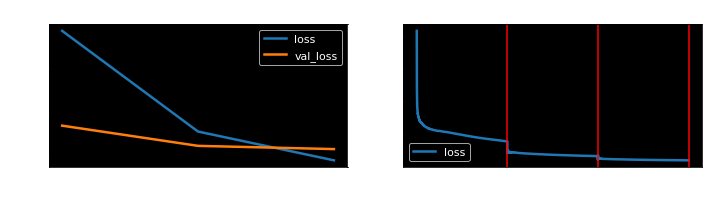

===== History =====
       loss  val_loss
0  0.383664  0.171583
1  0.158398  0.126400
2  0.094028  0.119176


In [6]:
model.plot_history()
print(model.history)

## Dataset analysis

In [8]:
config = model.get_dataset_config(batch_size = 32, is_validation = False, shuffle_size = 0)
ds = prepare_dataset(dataset, ** config)

test_dataset_time(ds)

99it [00:08, 12.27it/s]


100 batchs in 8.068 sec sec (12.395 batch / sec)

Batch infos : 
Element 0 : 
 Element 0 : shape : (32, 1019, 80) - type : <dtype: 'float32'> - min : -5.697 - max : 5.426
 Element 1 : shape : (32,) - type : <dtype: 'int32'> - min : 317.000 - max : 1019.000
 Element 2 : shape : (32, 46) - type : <dtype: 'int32'> - min : 0.000 - max : 994.000
 Element 3 : shape : (32,) - type : <dtype: 'int32'> - min : 11.000 - max : 46.000
Element 1 : 
 Element 0 : shape : (32, 46) - type : <dtype: 'int32'> - min : 0.000 - max : 994.000
 Element 1 : shape : (32,) - type : <dtype: 'int32'> - min : 11.000 - max : 46.000


8.067805290222168

In [ ]:
""" Classic hyperparameters """
epochs     = 2
batch_size = 12
valid_batch_size = 2 * batch_size
train_prop = 0.9
train_size = min(1024 * 5 * batch_size, int(len(dataset) * train_prop))
valid_size = min(len(dataset) - train_size, 250 * batch_size)

shuffle_size    = batch_size * 16
pred_step       = -10 # make a prediction after every epoch
augment_prct    = 0.25

""" Custom training hparams """
trim_audio      = False
reduce_noise    = False
trim_threshold  = 0.075
max_silence     = 0.25
trim_method     = 'window'
trim_mode       = 'start_end'

trim_mel     = False
trim_factor  = 0.6
trim_mel_method  = 'max_start_end'

max_input_length = 256 * 3

""" Training """

# this is to normalize dataset usage so that you can use a pre-splitted dataset or not
# without changing anything in the training configuration
if train is None or valid is None:
    train, valid = train_test_split(
        dataset, train_size = train_size, valid_size = valid_size, shuffle = True
    )

print("Training samples   : {} - {} batches".format(
    len(train), len(train) // batch_size
))
print("Validation samples : {} - {} batches".format(
    len(valid), len(valid) // valid_batch_size
))


In [8]:
from loggers import set_level
set_level('info')

Encoded text : [ 71  14  72   9  84  75 110   1  98  53  34   6   4  31 128 128 128 128
 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128
 128 128 128 128 128 128 128 128 128 128 128]
Decoded text : qu'aurais-je du en faire
Predicted : c'aurais-je du en faire
Inference : courais-je du en faire


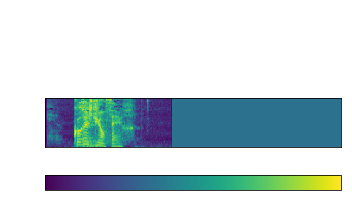

Encoded text : [ 41   5   9  63   3  68  11   1  25  14  22   3  41  73  19  31   2   2
  90  30  10  36  41  17   8  15   6   2   2  90  32  78   7  19  10  13
  80 100  32   5   9   8  15  57   3   4  80]
Decoded text : le rythme c'est le redressement puis le dépassement la production pour la répartition
Predicted : le rythme c'est le redressement puis le dépassement la production pour la répartition
Inference : le rythme c'est le redressement puis le dépassement la production pour la répartition


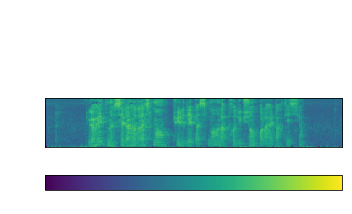

Encoded text : [  5   1  11  11  37  10   1  12  79  13   9  18  78   8  13  36   1  71
  14  59   5  63  64   9  46 106   5  10   2  28   1  53  34   9  37  13
   1  42 106  53  33  12  62  11   6  27  21   1 128]
Decoded text : emmanuel macron précise qu'il y aurait une usine en france et une en allemagne
Predicted : emmanuel macron précise qu'il y aurait une usine en france et une en allemagne
Inference : emmanuel macron précise qu'il y aurait une usine en france et une en allemagne


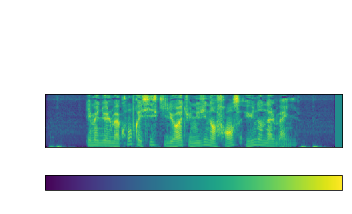

Encoded text : [  5   9  10   1  34  84   2  65  47   6  28  19  10  13  71   6   3  31
  75  23  28  27   3  75  19   4  67  75   2   1  15   3  17 103  25  48
   2  34  49   3  75  19   1  75  45   9  37  13   1]
Decoded text : rue faissal vainduc quatre-vingt-dix-sept deux cents fort-de-france
Predicted : rue fessal venddduc quatre-vingt-dix-sept deux cents fort-de-france
Inference : rue fessal vaduc quatre-vingt-dix-sept deux cents fort-de-france


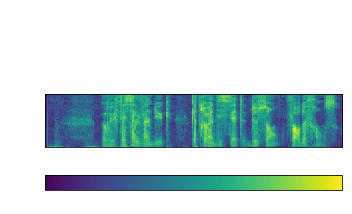

Encoded text : [ 60 107  46  99  21  10 100  74   2  25  44  12  55   2  42  20   6  79
   3   4 105  71  14  59  33   4  11  46  33  99  13   1  23   7   4   9
  29  10   4  75  11  91  11   1]
Decoded text : il était connu pour ses couleurs et sa matière qu'il aimait a concevoir lui-même
Predicted : il était connu pour ses couleurs et sa matière qu'il aimait a concevoir lui-même
Inference : il était connu pour ses couleurs et sa matière qu'il aimait a concevoir lui-même


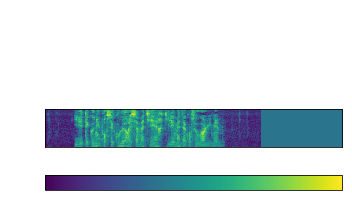

Encoded text : [ 60  78 108  33  28   2   4  34  24  11  90  41  99   3  76  62  16  29
  14  57  11   8   1  16  29  14   8  13  18   7  11   4   1  42  16  32
  30   7  12  38   4  70   1 128]
Decoded text : il prend ainsi fermement le controle de l'armée de l'économie et de la politique
Predicted : il prend ainsi fermement le controle de l'armée de l'économie et de la politique
Inference : il prend ainsi fermement le controle de l'armée de l'économie et de la politique


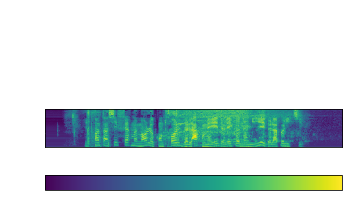

Encoded text : [  5  44 104   3  56  26   7  11  48   2   5  44  39  44   2  17   8  27
   9  28  27   7  12   4  18   2  98 101  72   3  86  20   6  13   2  96
  41  81   9  37  19  81   9  40   4  24]
Decoded text : ou sont les moments ou nous dégringolions du haut des sacs dans le grand grenier
Predicted : ou sont les moments ou nous dégringolions du haut des sacs dans le grand grenier
Inference : ou sont les moments ou nous dégringolions du haut des sacs dans le grand grenier


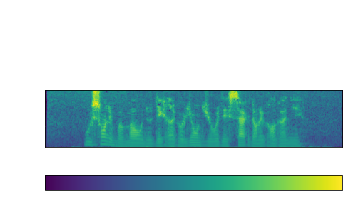

Encoded text : [ 26   7   4  93  73  27   6  27  21   6   4  79  88   6  11  35  31 128
 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128
 128 128 128 128 128 128 128 128 128 128]
Decoded text : moi je regagnai ma chambre
Predicted : moi je regagnai ma chambre
Inference : moi je regagnai ma chambre


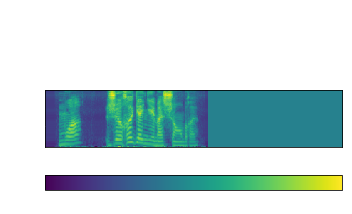

Encoded text : [ 64  25  12   6   2   2  90  81   8  21   8  51  12  34   6  35   4  37
  25  37  13   1  12  12   6  51  99   2  24  23   1 104  79  59  12   7
   3  83   6  85   1  33  29  14  36   2  10   1  16  89   3   3   1 107
   6  15   1]
Decoded text : au classement général fabian cancellara conserve son maillot jaune a l'issue de cette étape
Predicted : au classement général fabian cancelaara conserve son maillot jaune a l'issue de cette étape
Inference : au classement général fabian cancelara conserve son maillot jaune a l'issue de cette étape


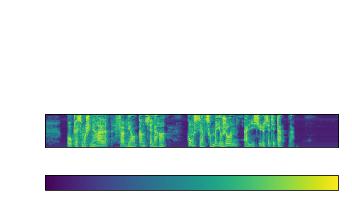

Encoded text : [ 32  99  13  59   4   6  80  83  10  19   4  13   4   6   4  31 102 106
  78   7  13   8  19  10  31  81  51   3  10  38   1  20  37   2  34  49
  11  65  38   8 128 128 128 128 128 128 128 128 128 128 128 128 128 128
 128 128 128]
Decoded text : la conciliation judiciaire est une procédure gratuite sans formalité
Predicted : la conciliation judiciaire est une procédure gratuite sans formalité
Inference : la conciliation judiciaire est une procédure gratuite sans formalité


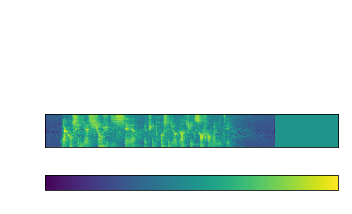

In [8]:
import logging

from models.stt.conformer_transducer import decode_transduction

ds = valid if valid is not None else dataset

config = model.get_dataset_config(batch_size = 2, is_validation = True, shuffle_size = 0)
ds = prepare_dataset(ds.sample(25, random_state = 0), ** config)

for batch in ds.take(5):
    inputs, (text, text_length) = batch
    pred  = model(inputs, training = False)
    infer = model.infer(inputs[:-2], decode = False)
    #print(infer.tokens)
    #*print(infer.blank_mask)
    pred  = model.decode_output(pred)
    infer = model.decode_output(infer)
    logging.getLogger('timer').log_time()
    for m, p, i, t in zip(inputs[0], pred, infer, text):
        print("Encoded text : {}\nDecoded text : {}".format(t, model.decode_text(t)))
        print("Predicted : {}".format(p.replace('_', '')))
        print("Inference : {}".format(i.replace('_', '')))
        plot_spectrogram(m)

## Tests

In [8]:
a = tf.zeros((model.audio_rate * 10,))
mel = model.mel_fn(a)
print("Mel shape for 10 audio sec : {}".format(tf.shape(mel)))

Mel shape for 10 audio sec : [   1 1001   80]


### Tests learning-rate scheduler

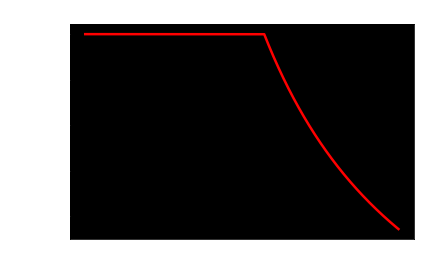

In [11]:
lr = model.get_optimizer().lr
lr.factor = 10
lr.plot(3500 * 5)

### Tests prediction and search

In [ ]:
from utils import plot
from utils.audio import resample_file

filename = '../__test_datas/audio_test.mp3'
filename = resample_file(filename, filename_out = filename.replace('.mp3', '_resampled.mp3'), new_rate = model.audio_rate)

n = 30

audio = load_audio(filename, rate = model.audio_rate, trim_silence = False)
print(len(audio) / model.audio_rate)
plot(audio)
display_audio(audio, rate = model.audio_rate)

pred = model.predict(filename, overwrite = False, time_window = n, time_step = n, batch_size = 16)
pred[0]['alignment'][:10]